In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing, metrics
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [2]:
# Membaca dataset (csv ke DataFrame)
df = pd.read_csv("milk.csv")

# Data Understanding

In [3]:
# Mengetahui jumlah baris dan kolom
print("Jumlah Baris : ", df.shape[0])
print("Jumlah Kolom : ", df.shape[1])

Jumlah Baris :  1059
Jumlah Kolom :  8


In [4]:
# Mengetahui tipe data pada setiap kolom
df.dtypes

pH            float64
Temprature      int64
Taste           int64
Odor            int64
Fat             int64
Turbidity       int64
Colour          int64
Grade          object
dtype: object

In [5]:
df = df.rename(columns={
    "Temprature": "Temperature",
    "Taste" : "Rasa",
    "Odor": "Bau",
    "Fat ": "Lemak",
    "Turbidity": "Kekeruhan",
    "Colour": "Warna",
    "Grade": "Kualitas"
})

In [6]:
# Melihat 10 teratas data
df.head(10)

,pH,Temperature,Rasa,Bau,Lemak,Kekeruhan,Warna,Kualitas
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium
5,6.6,37,1,1,1,1,255,high
6,5.5,45,1,0,1,1,250,low
7,4.5,60,0,1,1,1,250,low
8,8.1,66,1,0,1,1,255,low
9,6.7,45,1,1,0,0,247,medium


In [7]:
# Melihat deskripsi statistik data
df.describe(include="all")

,pH,Temperature,Rasa,Bau,Lemak,Kekeruhan,Warna,Kualitas
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,429
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415,NaN
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424,NaN
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000,NaN
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000,NaN
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000,NaN
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000,NaN


In [8]:
# Mengetahui outlier pada data
q1 = df.select_dtypes(exclude=['object']).quantile (0.25)
q3 = df.select_dtypes(exclude=['object']).quantile (0.75)
iqr = q3-q1
iqr

pH             0.3
Temperature    7.0
Rasa           1.0
Bau            1.0
Lemak          1.0
Kekeruhan      1.0
Warna          5.0
dtype: float64

Text(0.5, 1.0, 'Persebaran Jumlah Data Kualitas Susu')

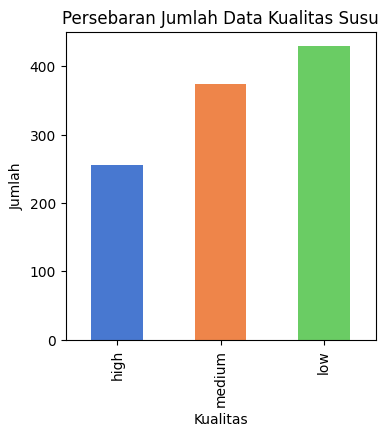

In [9]:
# Melihat sebaran kualitas susu
milk_quality = df.groupby('Kualitas').count()["pH"].sort_values()
plt.figure(figsize=(4, 4))
milk_quality.plot(kind="bar", color=sns.color_palette("muted"))
plt.ylabel('Jumlah')
plt.title('Persebaran Jumlah Data Kualitas Susu')

<Axes: >

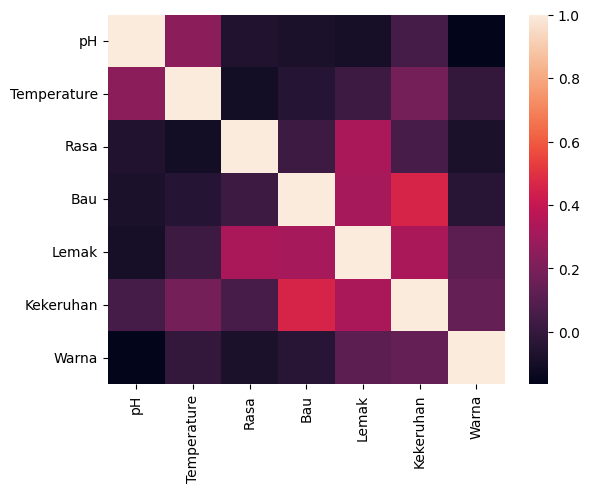

In [10]:
# Visualisasi Korelasi dengan heatmap
sns.heatmap(df.select_dtypes(exclude="object").corr())

Kesimpulan korelasi kualitas susu:
- Kekeruhan dan Kadar lemak memiliki pengaruh yang cukup tinggi terhadap bau susu
- Kadar Lemak memiliki pengaruh yang cukup tinggi terhadap rasa susu
- kadar asam (pH) dan suhu susu tidak berpengaruh pada rasa susu

In [11]:
# Nendeteksi outlier pada data
outlier_filter = (df.select_dtypes(exclude=['object']) < q1 - 1.5 * iqr) | (df.select_dtypes(exclude=['object']) > q3 + 1.5 * iqr)
outlier_filter

,pH,Temperature,Rasa,Bau,Lemak,Kekeruhan,Warna
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,True,True,False,False,False,False,False
3,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1054,False,False,False,False,False,False,False
1055,False,False,False,False,False,False,False
1056,True,False,False,False,False,False,False
1057,False,False,False,False,False,False,False


Diketahui terdapat data-data pencilan (outlier) pada kolom `pH`, `Warna`, dan `Temperature`.

In [12]:
for col in outlier_filter.columns:
    if df[col].dtype != object:
        print('Nama Kolom:',col)
        print(outlier_filter[col].value_counts())
        print('-------------------')

Nama Kolom: pH
pH
False    680
True     379
Name: count, dtype: int64
-------------------
Nama Kolom: Temperature
Temperature
False    956
True     103
Name: count, dtype: int64
-------------------
Nama Kolom: Rasa
Rasa
False    1059
Name: count, dtype: int64
-------------------
Nama Kolom: Bau
Bau
False    1059
Name: count, dtype: int64
-------------------
Nama Kolom: Lemak
Lemak
False    1059
Name: count, dtype: int64
-------------------
Nama Kolom: Kekeruhan
Kekeruhan
False    1059
Name: count, dtype: int64
-------------------
Nama Kolom: Warna
Warna
False    1027
True       32
Name: count, dtype: int64
-------------------


In [13]:
ph_outliers_percentage = len(outlier_filter[outlier_filter.pH==True]) / len(df['pH']) * 100
print(f'Persentase data outlier pada kolom pH: {ph_outliers_percentage}')

temp_outliers_percentage = len(outlier_filter[outlier_filter.Temperature==True]) / len(df['Temperature']) * 100
print(f'Persentase data outlier pada kolom Temperature: {temp_outliers_percentage}')

fat_outliers_percentage = len(outlier_filter[outlier_filter.Warna==True]) / len(df['Warna']) * 100
print(f'Persentase data outlier pada kolom Warna: {fat_outliers_percentage}')

Persentase data outlier pada kolom pH: 35.78847969782814
Persentase data outlier pada kolom Temperature: 9.726156751652502
Persentase data outlier pada kolom Warna: 3.0217186024551466


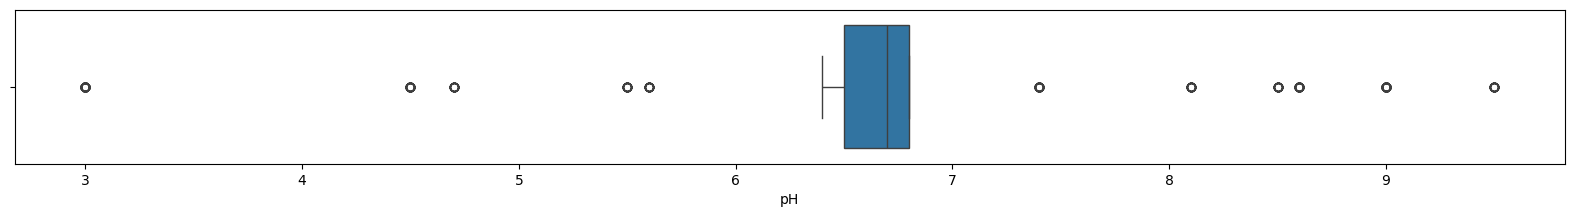

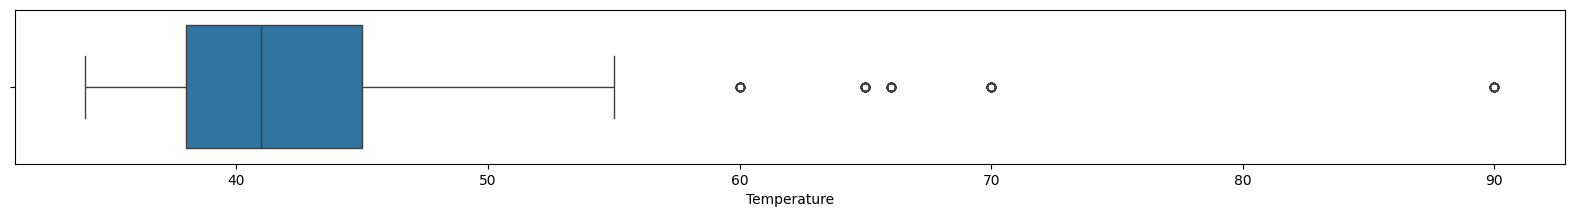

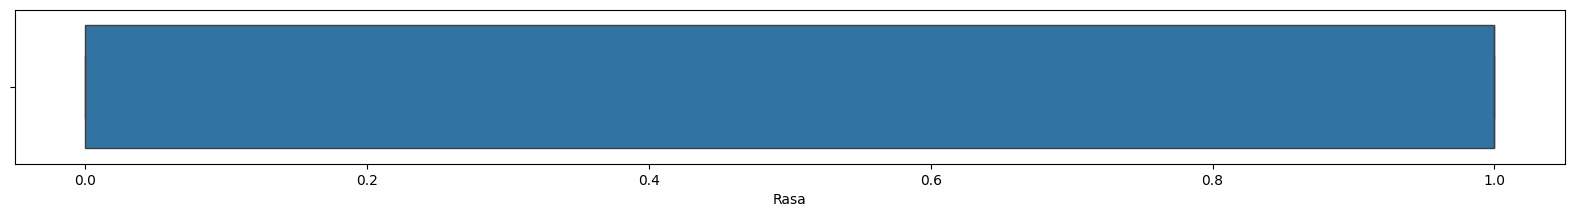

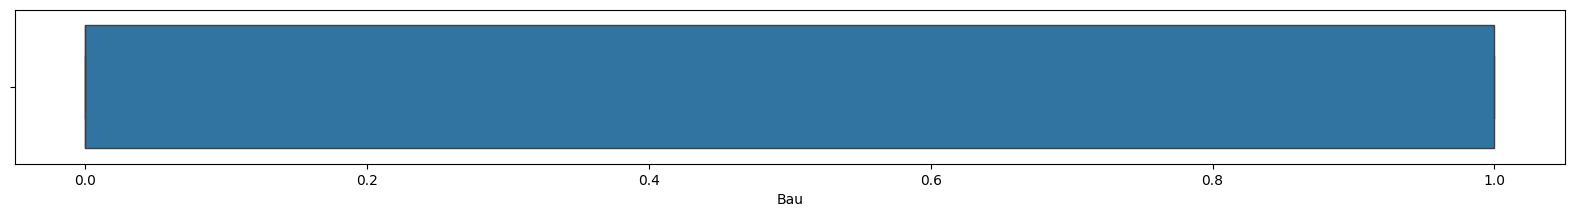

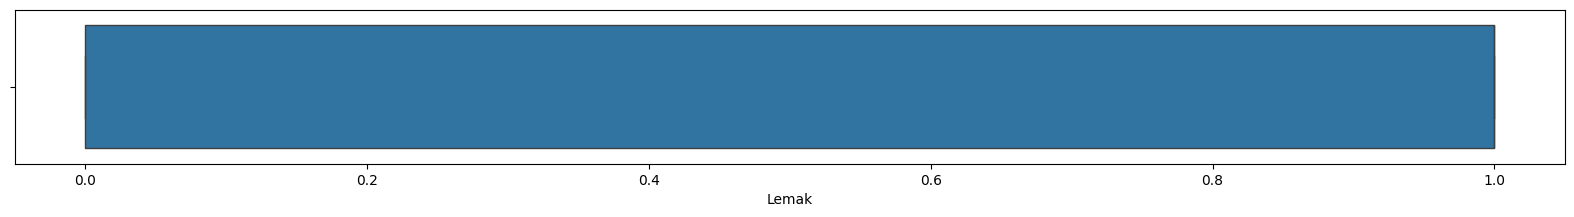

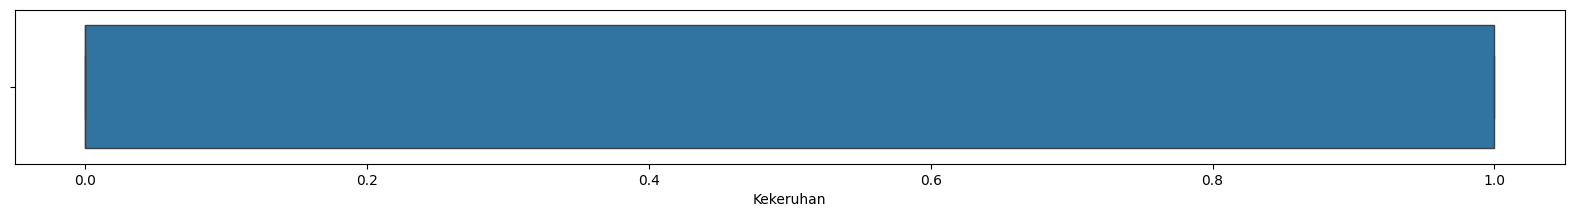

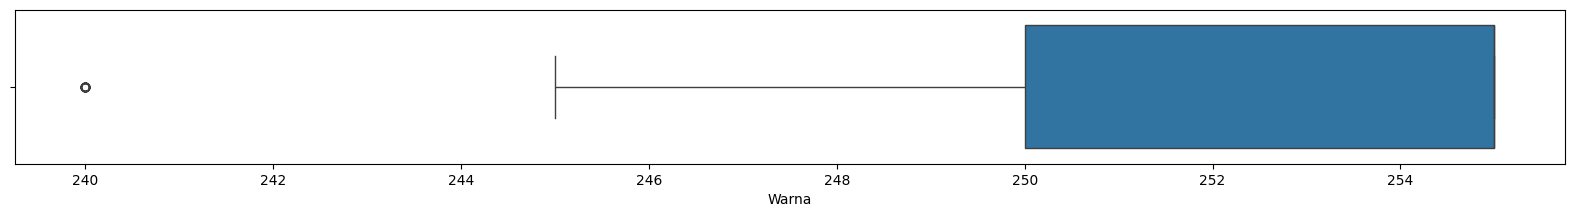

In [14]:
# Visualisasi Data Outlier dengan BoxPlot
df_outlier = df.select_dtypes(exclude=['object'])
for column in df_outlier:
    plt.figure(figsize=(20,2))
    sns.boxplot(data=df_outlier, x=column)

Box Plot menunjukkan:
- Kolom `pH` memiliki data pencilan pada lower bound dan upper bound
- Kolom `Temperature` memiliki data pencilan pada upper bound
- Kolom `Warna` memiliki data pencilan pada lower bound

# Data Preparation

## Data Cleaning

In [15]:
# Winsorizing data outliers
df['pH'] = winsorize(df['pH'], limits=[0, 0.05])
df['Temperature'] = winsorize(df['Temperature'], limits=[0, 0.05])
df['Warna'] = winsorize(df['Warna'], limits=[0, 0.05])

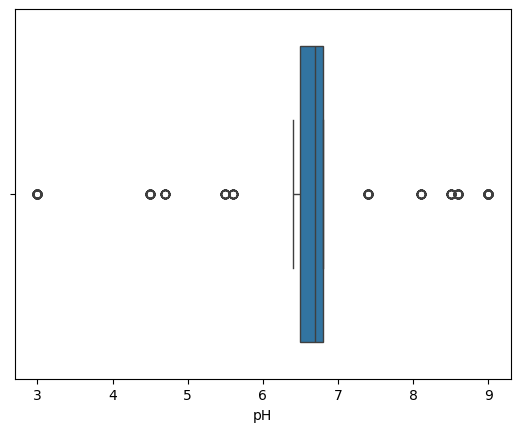

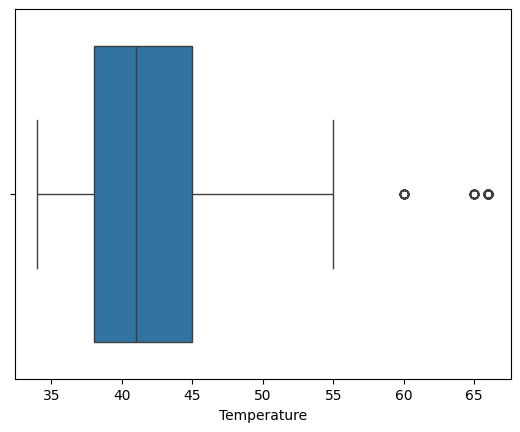

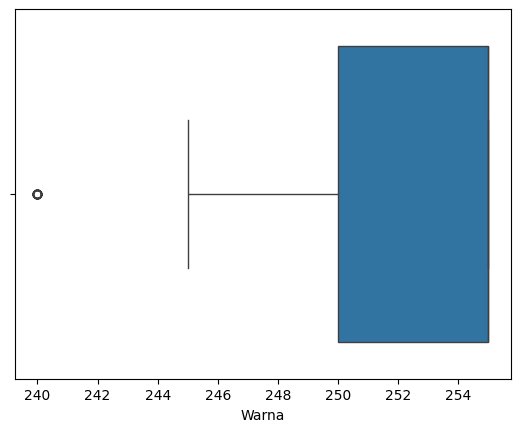

In [16]:
# Menampilkan kembali data setelah winsorizing
sns.boxplot(data=df, x=df['pH'])
plt.show()

sns.boxplot(data=df, x=df['Temperature'])
plt.show()

sns.boxplot(data=df, x=df['Warna'])
plt.show()

## Transformasi Data

In [17]:
df.isna().sum()

pH             0
Temperature    0
Rasa           0
Bau            0
Lemak          0
Kekeruhan      0
Warna          0
Kualitas       0
dtype: int64

Karena tidak ada data yang hilang, maka tidak perlu melakukan imputasi data.

In [18]:
df.dtypes

pH             float64
Temperature      int64
Rasa             int64
Bau              int64
Lemak            int64
Kekeruhan        int64
Warna            int64
Kualitas        object
dtype: object

In [19]:
df.head()

,pH,Temperature,Rasa,Bau,Lemak,Kekeruhan,Warna,Kualitas
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,66,1,1,1,1,246,low
3,9.0,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


Karena sebagian besar data numerik merupakan bilangan bulat dan data pada kolom `pH` yang merepresentasikan dengan 1 angka di belakang koma. Normalisasi/Standarisasi tidak diperlukan

In [20]:
# Labeling data untuk kolom kategorikal
cat_col = ['Kualitas']

le = preprocessing.LabelEncoder()
df[cat_col] = df[cat_col].apply(le.fit_transform)

In [21]:
df.head()

,pH,Temperature,Rasa,Bau,Lemak,Kekeruhan,Warna,Kualitas
0,6.6,35,1,0,1,0,254,0
1,6.6,36,0,1,0,1,253,0
2,8.5,66,1,1,1,1,246,1
3,9.0,34,1,1,0,1,255,1
4,6.6,37,0,0,0,0,255,2


# Data Modeling

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
# Split data
x = df.iloc[:, 0:-1].values
y = df.iloc[:, -1].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [24]:
knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(x_train, y_train)
k = KFold(n_splits=5)

score = cross_val_score(knn, x_train, y_train, scoring = 'accuracy', cv = k).mean()
print(f'Akurasi data training: {round(score, 3)}')

Akurasi data training: 0.992


In [25]:
y_pred = knn.predict(x_test)
print(f"Akurasi data test: {round(metrics.accuracy_score(y_test, y_pred), 3)}")

Akurasi data test: 0.994


In [26]:
report = metrics.classification_report(y_test, y_pred, target_names=["High", "Medium", "Low"])
print(report)

              precision    recall  f1-score   support

        High       0.97      1.00      0.99        71
      Medium       1.00      1.00      1.00       142
         Low       1.00      0.98      0.99       105

    accuracy                           0.99       318
   macro avg       0.99      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318



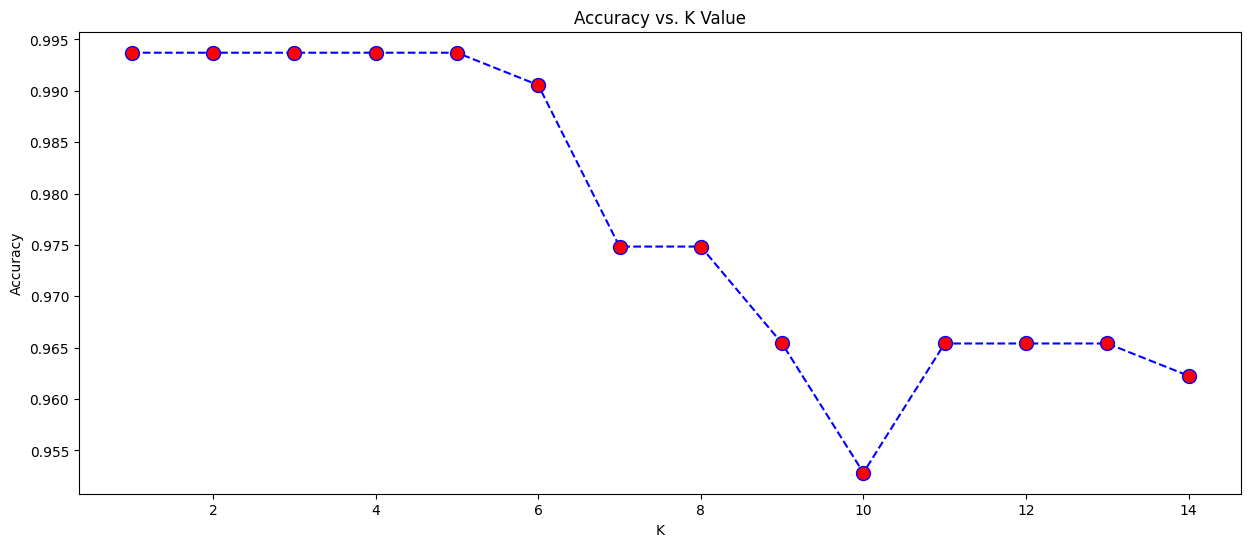

In [27]:
accuracy = []

for i in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    accuracy_i = metrics.accuracy_score(y_test, pred_i)
    accuracy.append(accuracy_i)

plt.figure(figsize=(15,6))
plt.plot(range(1,15, 1), accuracy, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()